# LLM Time Series Agent - Demo

This notebook demonstrates the two-stage LLM agent for time series analysis:

**Stage 1:** Data → Features → Baseline Models → LLM Analytical Report

**Stage 2:** Report → LLM Code Generation → Execution → Results

---

## Setup

In [16]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load environment variables
load_dotenv('../.env')

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Generation

Let's explore the available datasets.

In [3]:
from data_generator import DataGenerator

gen = DataGenerator()

print("Available datasets:")
for name in gen.get_all_datasets().keys():
    print(f"  - {name}")

Available datasets:
  - synthetic_sine
  - synthetic_trend_seasonal
  - physics_damped_oscillator
  - physics_lorenz
  - physics_radioactive_decay
  - real_stock
  - real_co2
  - real_airline


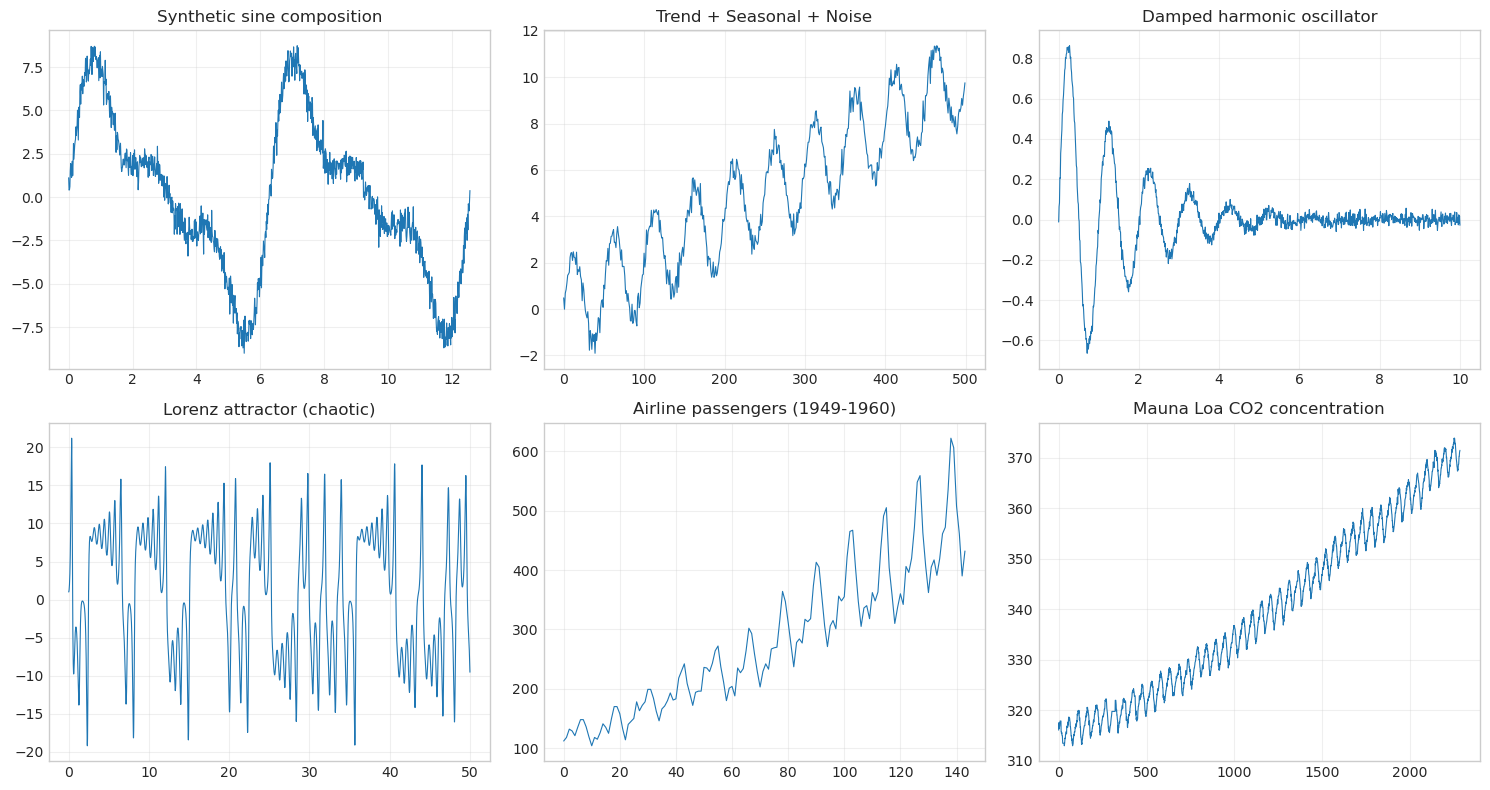

In [4]:
# Load and visualize different datasets
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

datasets = [
    'synthetic_sine',
    'synthetic_trend_seasonal', 
    'physics_damped_oscillator',
    'physics_lorenz',
    'real_airline',
    'real_co2'
]

for ax, name in zip(axes.flatten(), datasets):
    try:
        data = gen.load(name)
        ax.plot(data.x, data.y, linewidth=0.8)
        ax.set_title(data.description)
        ax.grid(True, alpha=0.3)
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {e}', ha='center')
        ax.set_title(name)

plt.tight_layout()
plt.show()

## 2. Feature Extraction

Extract statistical features from a time series.

In [5]:
from feature_extractor import TSFeatureExtractor

# Load synthetic sine data
data = gen.load('synthetic_sine')

# Extract features
extractor = TSFeatureExtractor(data.y, data.x)
features = extractor.extract_all()

# Print summary
print(extractor.get_summary())

Time Series Analysis Summary:

Length: 1000 points
Mean: 0.0039, Std: 4.3856
Range: [-8.8400, 8.8065]

Trend: downward (strength=0.21, slope=-0.006896)
Seasonality: No (period~500, strength=0.00)
Stationarity: stationary (ADF p-value=0.0005788287038425607)

Autocorrelation: ACF(1)=0.986, Strong
Distribution: skewness=-0.019, kurtosis=-0.709
Complexity: Hurst≈0.773 (trending)



In [6]:
# Show all features
import json
print(json.dumps(features, indent=2, default=str))

{
  "length": 1000,
  "mean": 0.003944117855503236,
  "std": 4.385630261519614,
  "min": -8.84000563910553,
  "max": 8.806489356676973,
  "range": 17.646494995782504,
  "median": -0.14594912696794193,
  "variance": 19.233752790756597,
  "coef_of_variation": 1111.9419911350606,
  "trend_slope": -0.0068964006058762906,
  "trend_intercept": 3.4486962204907106,
  "trend_r_squared": 0.20606263666533045,
  "trend_p_value": 5.456861895228486e-52,
  "trend_strength": 0.20606263666533053,
  "trend_direction": "downward",
  "estimated_period": 500,
  "seasonal_strength": 0.0,
  "has_seasonality": false,
  "adf_statistic": -4.233114359109373,
  "adf_pvalue": 0.0005788287038425607,
  "is_stationary": "True",
  "stationarity_interpretation": "stationary",
  "acf_lag1": 0.9861847548698986,
  "acf_lag2": 0.9855420904443839,
  "pacf_lag1": 0.9871719267966952,
  "pacf_lag2": 0.5103139191213978,
  "acf_decay_lag": 40,
  "has_strong_autocorr": "True",
  "skewness": -0.019239162839085326,
  "kurtosis": -0

## 3. Baseline Models

Run baseline models for comparison.

In [7]:
from baseline_models import BaselineModels

# Run baseline models
baseline = BaselineModels(data.y, data.x, train_ratio=0.8)
baseline.run_all()

# Print summary
baseline.print_summary()

20:44:28 - cmdstanpy - INFO - Chain [1] start processing
20:44:28 - cmdstanpy - INFO - Chain [1] done processing



BASELINE MODELS COMPARISON
Model                           RMSE        MAE         R²
------------------------------------------------------------
ARIMA(1, 1, 1)                3.5131     2.6930    -1.1299
AR(10)                        3.8323     2.9726    -1.5345
ExponentialSmoothing          3.7588     2.8890    -1.4382
GPR                           6.7653     5.8099    -6.8986
Prophet                       2.1416     1.6102     0.2085
------------------------------------------------------------
Best model: Prophet (RMSE=2.1416)


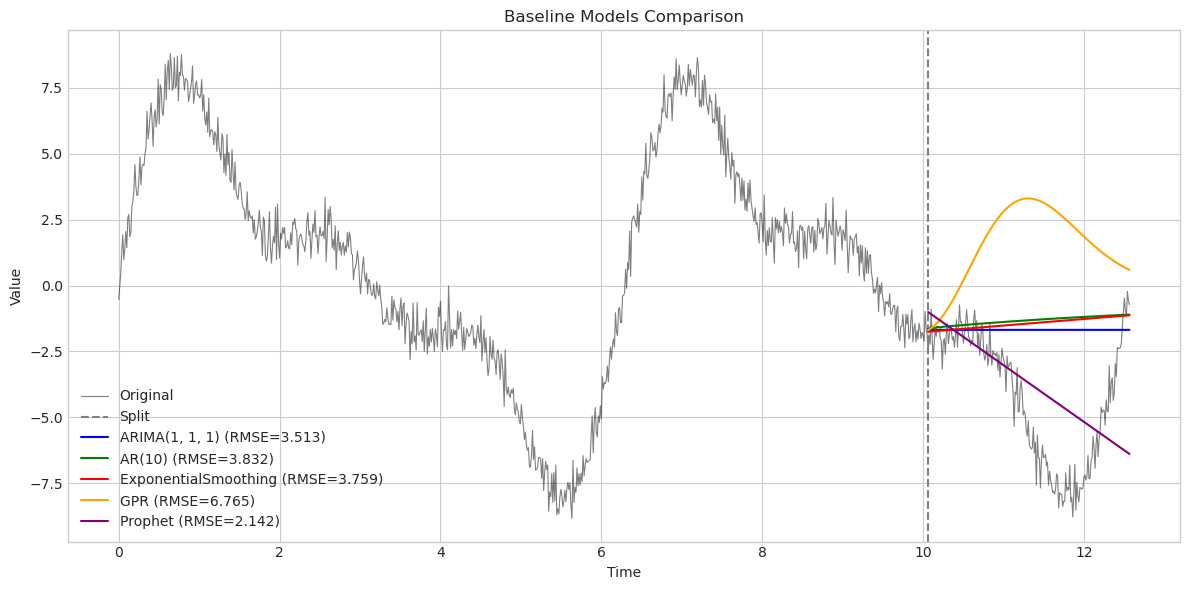

In [8]:
# Visualize baseline predictions (using actual x coordinates)
fig, ax = plt.subplots(figsize=(12, 6))

# Use actual x coordinates from data
x = data.x

# Original data
ax.plot(x, data.y, 'k-', alpha=0.5, label='Original', linewidth=0.8)

# Train/test split
split_idx = int(len(data.y) * 0.8)
ax.axvline(x=x[split_idx], color='gray', linestyle='--', label='Split')

# Predictions from each baseline model
colors = ['blue', 'green', 'red', 'orange', 'purple']
for (name, result), color in zip(baseline.results.items(), colors):
    if result.success and len(result.forecast) > 0:
        x_test = x[split_idx:split_idx + len(result.forecast)]
        ax.plot(x_test, result.forecast, color=color, 
               label=f'{result.name} (RMSE={result.metrics["rmse"]:.3f})', linewidth=1.5)

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Baseline Models Comparison')
plt.tight_layout()
plt.show()

## 4. State Space Visualization

In [9]:
from state_space_viz import StateSpaceVisualizer

viz = StateSpaceVisualizer(data.y, data.x)

# Phase space embedding (3D) - Interactive with Plotly
fig_plotly = viz.plot_phase_space(embed_dim=3, delay=1, interactive=True)
fig_plotly.show()

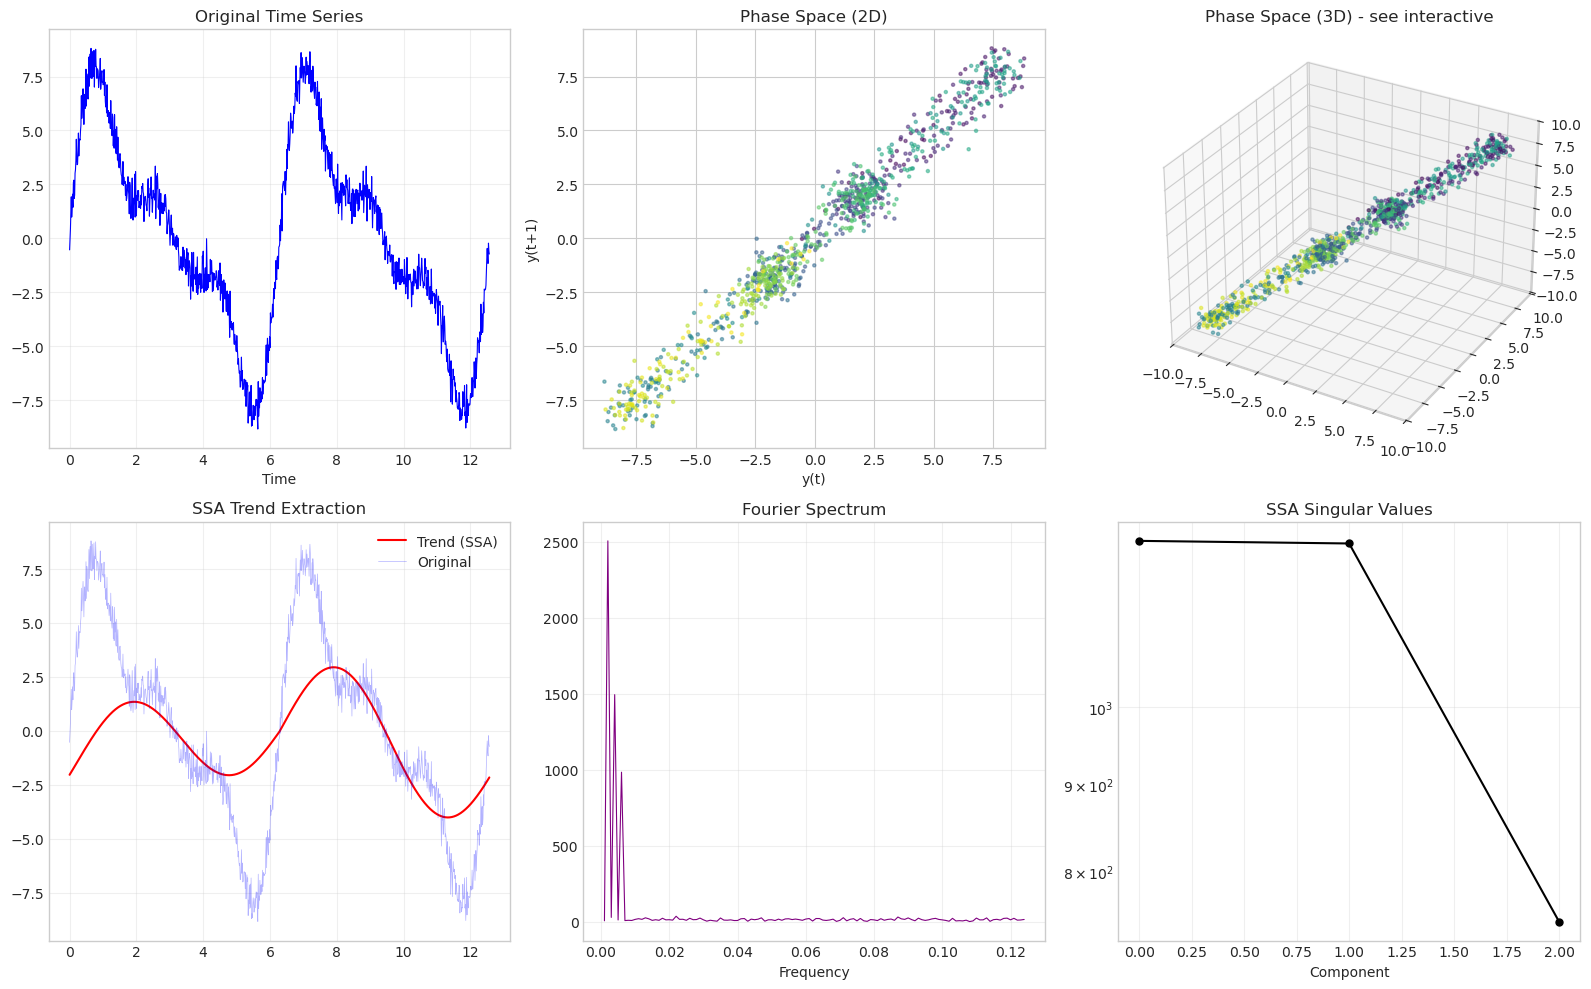

In [10]:
# Comprehensive state space visualization with plot_all()
# Returns: (matplotlib_figure, plotly_3d_figure)
fig_mpl, fig_plotly_3d = viz.plot_all(interactive_3d=True)

# Show matplotlib figure (SSA, Fourier, Phase Space 2D, etc.)
plt.show()

# Show interactive 3D phase space
if fig_plotly_3d is not None:
    fig_plotly_3d.show()

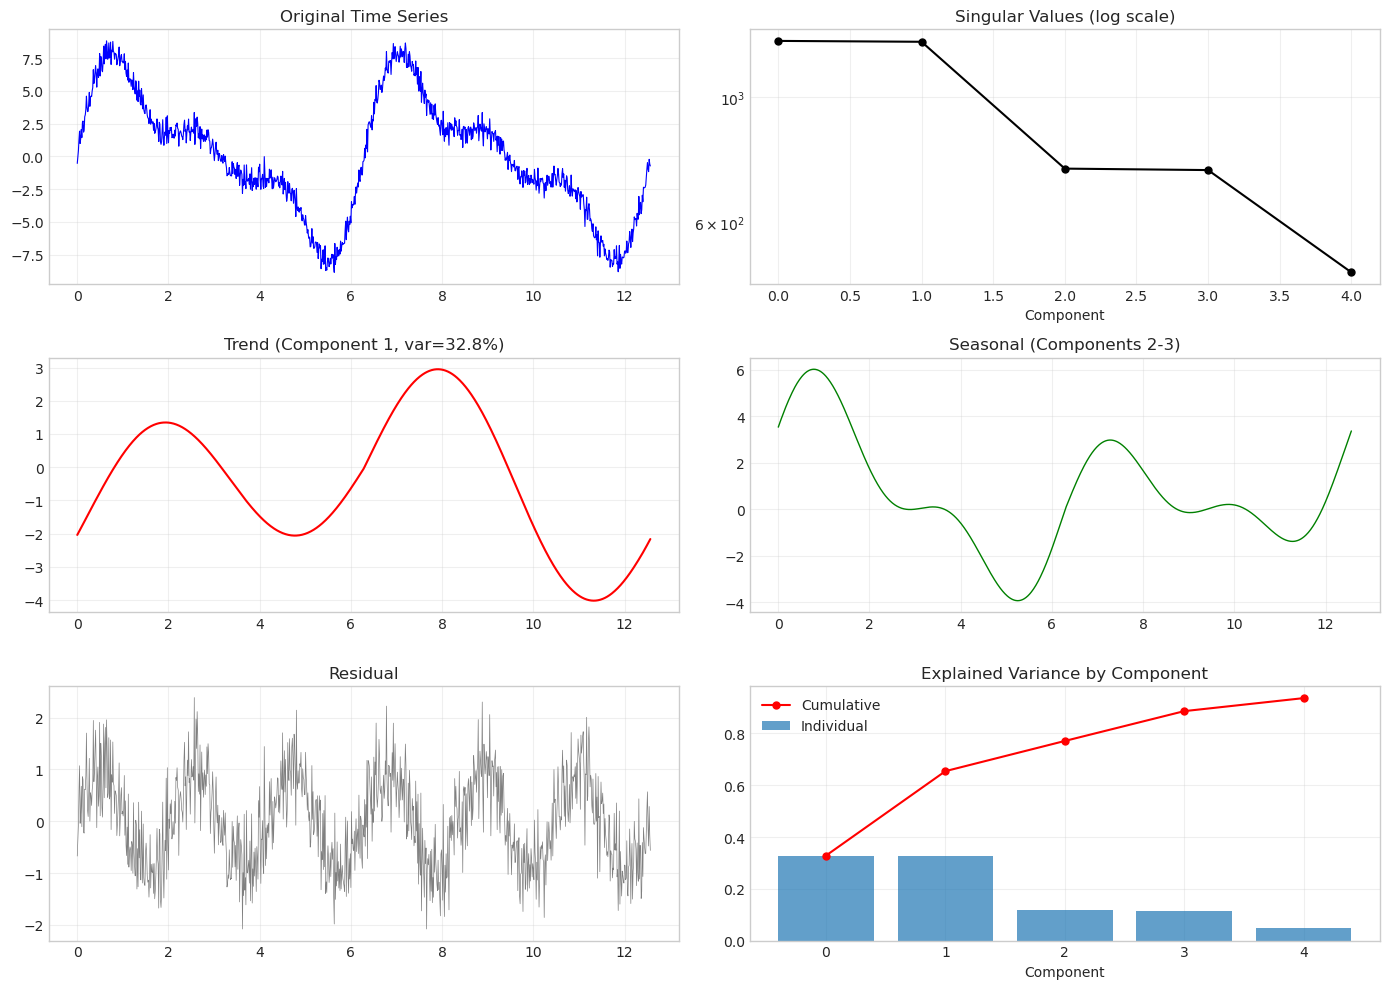

In [11]:
# SSA decomposition
fig = viz.plot_ssa(n_components=5)
plt.show()

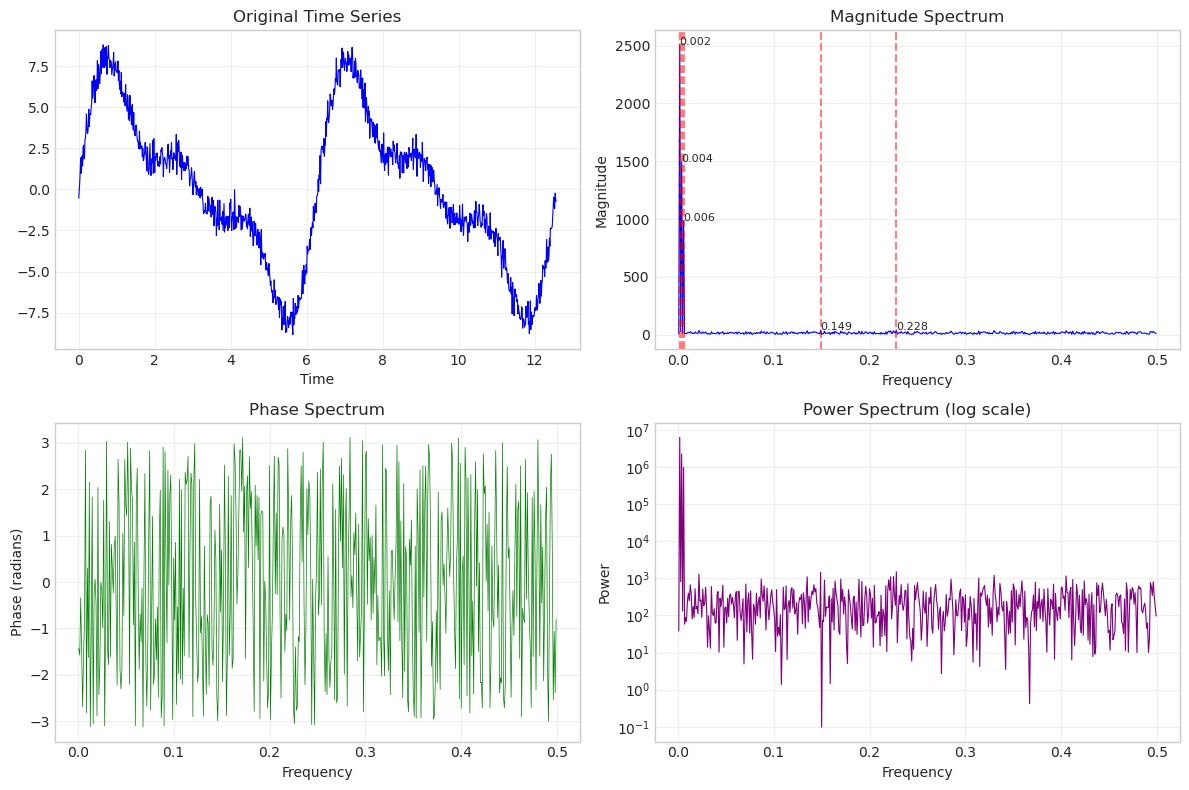

In [12]:
# Fourier analysis
fig = viz.plot_fourier()
plt.show()

## 5. LLM Stage 1: Analytical Report

Generate an analytical report using LLM.

In [15]:
from llm_stage1_reporter import LLMAnalyticalReporter

# Initialize reporter
reporter = LLMAnalyticalReporter()

# Get baseline metrics
baseline_metrics = baseline.get_metrics_summary()

# Generate report
print("Generating analytical report...")
report = reporter.generate_report(
    features=features,
    baseline_metrics=baseline_metrics,
    context=data.context,
    user_prompt="Recommend the best model for forecasting this time series"
)

print(json.dumps(report, indent=2, default=str))

ValueError: OpenAI API key not provided. Set OPENAI_API_KEY in .env

In [ ]:
# Human-readable report
text_report = reporter.generate_text_report(
    features=features,
    baseline_metrics=baseline_metrics,
    context=data.context
)
print(text_report)

TIME SERIES ANALYTICAL REPORT

## SUMMARY
The time series exhibits a downward trend with strong autocorrelation, indicating persistence in the data. It is stationary with no seasonality, suggesting that the underlying process is stable over time.

## CHARACTERISTICS
  - Trend: Weak downward trend
  - Seasonality: None
  - Stationarity: Stationary, indicating that the mean and variance are constant over time, allowing for reliable modeling.
  - Noise Level: Medium
  - Complexity: Moderate

## STATE SPACE RECOMMENDATION
  Method: SSA
  Embedding dim: 3
  Delay: 1
  Reason: SSA is effective for extracting trends and reducing noise, which is beneficial given the presence of Gaussian noise.

## RECOMMENDED TRANSFORMATIONS
  1. Differencing
     Reason: To remove any potential trends and stabilize the mean, although the series is already stationary.

## RECOMMENDED MODELS
  1. ARIMA
     Reason: ARIMA(1, 1, 1) shows reasonable performance with low RMSE and is suitable for stationary data wit

## 6. LLM Stage 2: Code Generation

Generate and execute processing code based on the analytical report.

In [ ]:
from llm_stage2_codegen import LLMCodeGenerator

# Initialize code generator
codegen = LLMCodeGenerator()

# Prepare data
ts_dict = data.to_dict()

# Generate code
print("Generating processing code...")
code = codegen.generate_code(ts_dict, report)

print("\n--- Generated Code ---")
print(code)
print("--- End Code ---")

Generating processing code...

--- Generated Code ---
```python
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from prophet import Prophet

def process_timeseries(x, y, description):
    try:
        # Train-test split (80/20)
        split_idx = int(len(y) * 0.8)
        x_train, x_test = x[:split_idx], x[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # Train ARIMA model
        model = ARIMA(y_train, order=(1, 1, 1)).fit()

        # Predict
        predictions = model.forecast(steps=len(y_test))

        # Compute metrics
        metrics = {
            'mse': float(mean_squared_error(y_test, predictions)),
    

In [ ]:
# Execute the generated code
print("Executing generated code...")
result = codegen.execute_code(ts_dict)

if result.success:
    print(f"\nSuccess! Metrics: {result.metrics}")
    
    # Visualize using our own plotting method (with actual x coordinates)
    fig = result.plot(data.y, x=data.x, description=data.description)
    plt.show()
else:
    print(f"\nFailed: {result.error_message}")

## 7. Full Pipeline

Run the complete pipeline with the TimeSeriesAgent.

In [ ]:
from main_pipeline import TimeSeriesAgent

# Initialize agent
agent = TimeSeriesAgent(verbose=True)

# Run pipeline on synthetic data with interactive 3D visualizations
result = agent.run(
    dataset_name='synthetic_sine',
    context='Synthetic time series for demonstration',
    user_prompt='Analyze and recommend the best forecasting approach',
    save_results=False,
    show_plots=True,
    interactive=True  # Enable interactive Plotly 3D visualizations
)

In [ ]:
# Print final results
print(f"\n{'='*50}")
print("FINAL RESULTS")
print(f"{'='*50}")
print(f"Dataset: {result.dataset_name}")
print(f"Success: {result.success}")
print(f"Best Baseline: {result.best_baseline_model} (RMSE={result.best_baseline_rmse:.4f})")
print(f"Final Metrics: {result.final_metrics}")
print(f"Execution Time: {result.execution_time:.2f}s")


FINAL RESULTS
Dataset: synthetic_sine
Success: True
Best Baseline: Prophet (RMSE=2.1626)
Final Metrics: {'mse': 11.293158908356894, 'rmse': 3.36052955772701, 'mae': 2.555873827271921, 'r2': -0.8564088746054102}
Execution Time: 47.76s


## 8. Try Different Datasets

Run the pipeline on physics and real-world data.

In [ ]:
# Physics: Damped oscillator
result_physics = agent.run(
    dataset_name='physics_damped_oscillator',
    context='Damped harmonic oscillator - physical pendulum with friction',
    user_prompt='Analyze the decay pattern and recommend model',
    save_results=False,
    show_plots=True,
    interactive=True  # Enable interactive Plotly 3D visualizations
)

In [ ]:
# Real data: Airline passengers
result_airline = agent.run(
    dataset_name='real_airline',
    context='Monthly airline passengers 1949-1960',
    user_prompt='Detect seasonality and forecast future values',
    save_results=False,
    show_plots=True,
    interactive=True  # Enable interactive Plotly 3D visualizations
)

In [ ]:
# Real data: Airline passengers
result_airline = agent.run(
    dataset_name='real_airline',
    context='Monthly airline passengers 1949-1960',
    user_prompt='Detect seasonality and forecast future values',
    save_results=False,
    show_plots=True,
    interactive=True  # Enable interactive Plotly 3D visualizations
)

In [ ]:
# Real data: Airline passengers
result_airline = agent.run(
    dataset_name='real_airline',
    context='Monthly airline passengers 1949-1960',
    user_prompt='Detect seasonality and forecast future values',
    save_results=False,
    show_plots=True,
    interactive=True  # Enable interactive Plotly 3D visualizations
)

## Summary

This demo showed the full two-stage LLM agent pipeline:

1. **Data Generation** - Synthetic, physics, and real-world data
2. **Feature Extraction** - Statistical analysis of time series
3. **Baseline Models** - ARIMA, AR, Exponential Smoothing, GPR
4. **State Space Visualization** - Phase space, SSA, Fourier
5. **LLM Stage 1** - Analytical report with recommendations
6. **LLM Stage 2** - Code generation and execution
7. **Full Pipeline** - End-to-end processing

The agent can analyze any time series and automatically:
- Extract relevant features
- Compare baseline models  
- Generate analytical insights
- Create optimized processing code
- Produce forecasts with visualizations